In [2]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree

In [1]:
### xgboost

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Modificar dimensiones predeterminadas de visibilidad de columnas y filas
x = 52
pd.set_option('display.max_columns', x) #Maximo de columnas a ver
pd.set_option('display.max_rows', x) #Maximo de Filas a ver

In [4]:
path_dataset = 'train.csv'
train = pd.read_csv(path_dataset)

In [5]:
path_dataset = 'test.csv'
test = pd.read_csv(path_dataset)

In [6]:
test.head()

,Opportunity_ID,Region,Billing_Country,Account_Type,Opportunity_Type,Account_Owner,Account_Name,Conversión_USD,Delivery_Quarter,TRF,promedio_preciov_region,promedio_preciov_paises,promedio_preciov_Account,promedio_preciov_Oportunity,promedio_preciov_vendedor,Wilsonxproporcion_region,Wilsonxproporcion_paises,Wilsonxproporcion_vendedor
0,10689,EMEA,Germany,Account_Type_0,Opportunity_Type_8,Person_Name_13,Account_Name_978,194006,Q2,0,246888.239174,325954.165775,116533.133558,87111.379883,278450.516274,0.514817,0.445687,0.639475
1,10689,EMEA,Germany,Account_Type_0,Opportunity_Type_8,Person_Name_13,Account_Name_978,94018,Q2,0,246888.239174,325954.165775,116533.133558,87111.379883,278450.516274,0.514817,0.445687,0.639475
2,10689,EMEA,Germany,Account_Type_0,Opportunity_Type_8,Person_Name_13,Account_Name_978,151334,Q2,0,246888.239174,325954.165775,116533.133558,87111.379883,278450.516274,0.514817,0.445687,0.639475
3,10690,EMEA,Germany,Account_Type_0,Opportunity_Type_8,Person_Name_13,Account_Name_978,291009,Q2,1,246888.239174,325954.165775,116533.133558,87111.379883,278450.516274,0.514817,0.445687,0.639475
4,10690,EMEA,Germany,Account_Type_0,Opportunity_Type_8,Person_Name_13,Account_Name_978,188037,Q2,0,246888.239174,325954.165775,116533.133558,87111.379883,278450.516274,0.514817,0.445687,0.639475


In [7]:
train['Stage']= (train['Stage'] == 'Closed Won') +0

In [8]:
for column in train.columns:
    if train[column].dtype == 'int32':
        train[column] = train[column].astype('float64')
print(train.dtypes)

Opportunity_ID                   int64
Region                          object
Billing_Country                 object
Account_Type                    object
Opportunity_Type                object
Account_Owner                   object
Account_Name                    object
Conversión_USD                   int64
Delivery_Quarter                object
TRF                              int64
Stage                          float64
promedio_preciov_region        float64
promedio_preciov_paises        float64
promedio_preciov_Account       float64
promedio_preciov_Oportunity    float64
promedio_preciov_vendedor      float64
Wilsonxproporcion_region       float64
Wilsonxproporcion_paises       float64
Wilsonxproporcion_vendedor     float64
dtype: object


In [9]:
### Target meaning encoding

In [10]:
# Import KFold
from sklearn.model_selection import KFold

In [11]:
def test_mean_target_encoding(train, test, target, categorical, alpha=5):
    # Calculate global mean on the train data
    global_mean = train[target].mean()
    
    # Group by the categorical feature and calculate its properties
    train_groups = train.groupby(categorical)
    category_sum = train_groups[target].sum()
    category_size = train_groups.size()
    
    # Calculate smoothed mean target statistics
    train_statistics = (category_sum + global_mean * alpha) / (category_size + alpha)
   
    # Apply statistics to the test data and fill new categories
    test_feature = test[categorical].map(train_statistics).fillna(global_mean)
    return test_feature.values

In [12]:
def train_mean_target_encoding(train, target, categorical, alpha=5):
    # Create 5-fold cross-validation
    kf = KFold(n_splits=5, random_state=123, shuffle=True)
    train_feature = pd.Series(index=train.index)
    
    # For each folds split
    for train_index, test_index in kf.split(train):
        cv_train, cv_test = train.iloc[train_index], train.iloc[test_index]
      
        # Calculate out-of-fold statistics and apply to cv_test
        cv_test_feature = test_mean_target_encoding(cv_train, cv_test, target, categorical, alpha)
        
        # Save new feature for this particular fold
        train_feature.iloc[test_index] = cv_test_feature       
    return train_feature.values

In [13]:
def mean_target_encoding(train, test, target, categorical, alpha=5):
  
    # Get the train feature
    train_feature = train_mean_target_encoding(train, target, categorical, alpha)
  
    # Get the test feature
    test_feature = test_mean_target_encoding(train, test, target, categorical, alpha)
    
    # Return new features to add to the model
    return train_feature, test_feature

In [14]:
columns = ['Region', 'Billing_Country', 'Account_Type','Opportunity_Type', 'Account_Owner', 'Account_Name','Delivery_Quarter']
for column in columns:     
    train[column], test[column] = mean_target_encoding(train=train,
                                                                test=test,
                                                                target='Stage',
                                                                categorical=column,
                                                                alpha=10)

<ipython-input-12-5785e70fe0cb>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  train_feature = pd.Series(index=train.index)


In [15]:
### Modelos

In [16]:
X = train.drop(['Stage'], axis=1)
y = train['Stage']

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

In [19]:
###Seleccion de Features

In [20]:
train.columns

Index(['Opportunity_ID', 'Region', 'Billing_Country', 'Account_Type',
       'Opportunity_Type', 'Account_Owner', 'Account_Name', 'Conversión_USD',
       'Delivery_Quarter', 'TRF', 'Stage', 'promedio_preciov_region',
       'promedio_preciov_paises', 'promedio_preciov_Account',
       'promedio_preciov_Oportunity', 'promedio_preciov_vendedor',
       'Wilsonxproporcion_region', 'Wilsonxproporcion_paises',
       'Wilsonxproporcion_vendedor'],
      dtype='object')

In [21]:
features = ['Opportunity_ID', 'Region', 'Billing_Country', 'Account_Type',
       'Opportunity_Type', 'Account_Owner', 'Account_Name', 'Conversión_USD',
       'Delivery_Quarter', 'TRF', 'promedio_preciov_region',
       'promedio_preciov_paises', 'promedio_preciov_Account',
       'promedio_preciov_Oportunity', 'promedio_preciov_vendedor',
       'Wilsonxproporcion_region', 'Wilsonxproporcion_paises',
       'Wilsonxproporcion_vendedor']

In [22]:
xg_reg = xgb.XGBClassifier()

In [23]:
xg_reg.fit(X_train[features],y_train)

C:\Users\Julia\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:32:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [24]:
preds = xg_reg.predict_proba(X_test[features])

In [25]:
# Import log_loss from sklearn
from sklearn.metrics import log_loss

In [26]:
print('Sklearn LogLoss: {:.5f}'.format(log_loss(y_test, preds)))

Sklearn LogLoss: 0.00014


In [29]:
preds_test = xg_reg.predict_proba(test[features])

In [30]:
preds_test = preds_test[:, 1]

In [31]:
preds_test

array([0.99987555, 0.99987555, 0.99987555, ..., 0.99987555, 0.99987555,
       0.99987555], dtype=float32)

In [32]:
test['Target']=preds_test

In [33]:
test['Target'].value_counts

<bound method IndexOpsMixin.value_counts of 0       0.999876
1       0.999876
2       0.999876
3       0.999876
4       0.999876
          ...   
2546    0.999876
2547    0.999876
2548    0.999876
2549    0.999876
2550    0.999876
Name: Target, Length: 2551, dtype: float32>

In [ ]:
test['Target'].head(50)

In [34]:
test = test.drop(['Target'], axis=1)

In [ ]:
sub= test[['Opportunity_ID','Target']]

In [ ]:
sub1=sub.groupby(['Opportunity_ID'], as_index=False).mean()

In [ ]:
sub1.shape

In [ ]:
sub1[['Opportunity_ID', 'Target']].to_csv('submission8.csv', index=False)

In [ ]:
###our submission scored 0.59095, which is not an improvement of your best score. Keep trying!

In [ ]:
test = test.drop(['Target'], axis=1)

In [ ]:
### Se cambia estrategia de validacion del modelo aK-fold cross validation

In [35]:
data_dmatrix = xgb.DMatrix(data=X[features],label=y)

In [36]:
params = {
'objective':'binary:logistic',     
'colsample_bynode': 1, 
'colsample_bytree' : 1, 
'gamma' : 0, 
'gpu_id':-1,
'importance_type' : 'gain', 
'interaction_constraints':'',
'learning_rate': 0.300000012, 
'max_delta_step': 0, 
'max_depth' : 6,
'min_child_weight':1, 
'missing' : 'nan', 
'monotone_constraints' : '()',
'n_estimators' : 00, 
'n_jobs' : 4, 
'num_parallel_tree': 1, 
'random_state' : 0,
'reg_alpha' : 0, 
'reg_lambda' : 1, 
'scale_pos_weight': 1, 
'subsample' : 1,
'tree_method' :'exact', 
'validate_parameters' : 1, 
'verbosity' : None
}

In [37]:
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10,
                    as_pandas=True, seed=123)

[14:37:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { importance_type, missing, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:37:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { importance_type, missing, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:37:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { importance_type, missing, n_estimators } might not b

In [38]:
cv_results.head()

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.437640,4.714045e-07,0.437639,9.428090e-07
1,0.296468,0.000000e+00,0.296465,0.000000e+00
2,0.207498,4.714045e-07,0.207499,1.414214e-06
3,0.147973,4.714045e-07,0.147971,4.714045e-07
4,0.106774,0.000000e+00,0.106776,0.000000e+00


In [39]:
print((cv_results["test-logloss-mean"]).tail(1))

34    0.000168
Name: test-logloss-mean, dtype: float64


In [40]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[14:37:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { importance_type, missing, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:37:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [41]:
from graphviz import Digraph
import pydotplus

<AxesSubplot:>

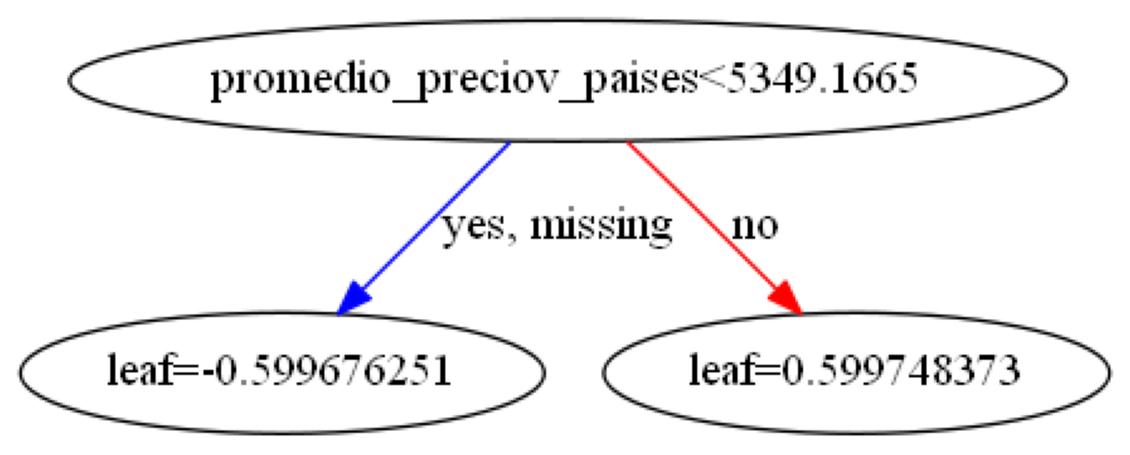

In [42]:
plt.rcParams['figure.figsize'] = [20, 20]
xgb.plot_tree(xg_reg,num_trees=0)

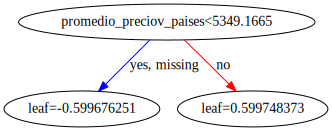

In [43]:
xgb.to_graphviz(xg_reg,num_trees=0)

<AxesSubplot:>

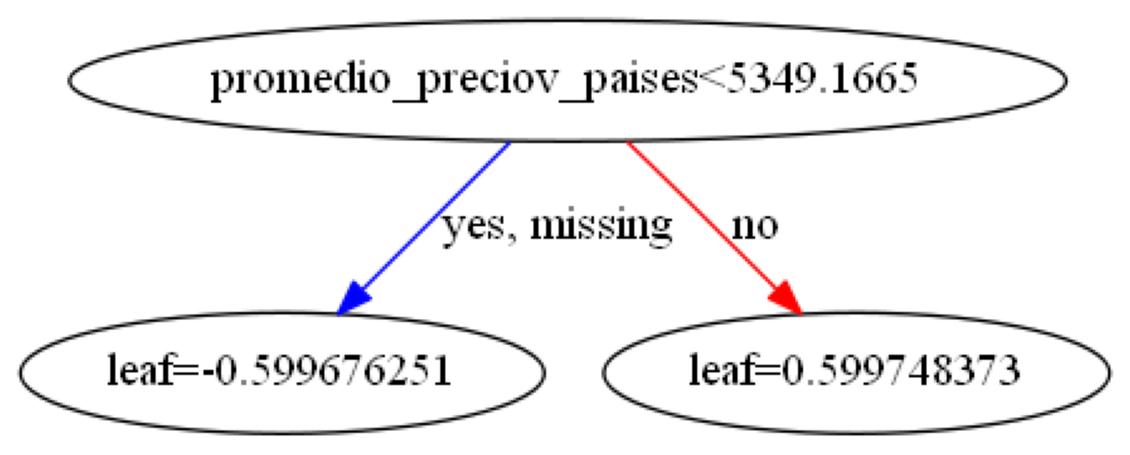

In [44]:
plt.rcParams['figure.figsize'] = [20, 20]
xgb.plot_tree(xg_reg,num_trees=0)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

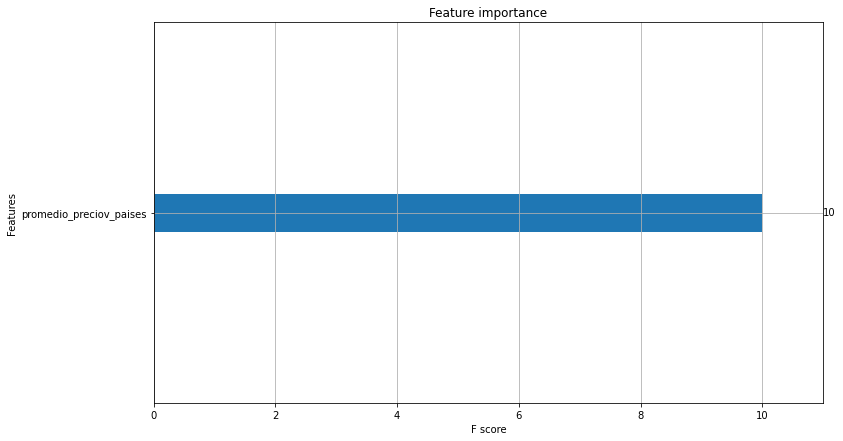

In [45]:
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(xg_reg)